In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
from os.path import join, dirname
import torch

# Modify lists 

In [3]:
vlcs_datasets = ["CALTECH", "LABELME", "PASCAL", "SUN"]


In [4]:
dname = dataset_list[0]
name_train, name_val, labels_train, labels_val = get_split_dataset_info(join('data', 'txt_lists', '%s_train.txt' % dname), 0.1)
name_train

NameError: name 'dataset_list' is not defined

In [110]:
[(i,i.split('/')[-1].split('_')[0] in vlcs_datasets) for i in glob('data/txt_lists/*')]

[('data/txt_lists/cartoon_train.txt', False),
 ('data/txt_lists/mnist_train.txt', False),
 ('data/txt_lists/cartoon_test.txt', False),
 ('data/txt_lists/sketch_train.txt', False),
 ('data/txt_lists/dslr_train.txt', False),
 ('data/txt_lists/art_painting_test.txt', False),
 ('data/txt_lists/mnist_m_test.txt', False),
 ('data/txt_lists/SUN_train.txt', True),
 ('data/txt_lists/photo_train.txt', False),
 ('data/txt_lists/art_pada_test.txt', False),
 ('data/txt_lists/dslr10_train.txt', False),
 ('data/txt_lists/CALTECH_train.txt', True),
 ('data/txt_lists/amazon_train.txt', False),
 ('data/txt_lists/webcam_train.txt', False),
 ('data/txt_lists/PASCAL_test.txt', True),
 ('data/txt_lists/CALTECH_test.txt', True),
 ('data/txt_lists/svhn_test.txt', False),
 ('data/txt_lists/amazon_test.txt', False),
 ('data/txt_lists/art_painting_train.txt', False),
 ('data/txt_lists/synth_digits_test.txt', False),
 ('data/txt_lists/realworld_pada_test.txt', False),
 ('data/txt_lists/webcam_test.txt', False),
 

In [115]:
for fl in glob('data/txt_lists/*'):
    if fl.split('/')[-1].split('_')[0] in vlcs_datasets:
        strings = []
        for string in open(fl).read().split('\n'):
            strings.append(string[string.lower().find('data')+5:])
        open(fl,'w').write('\n'.join(strings))        

In [113]:
'\n'.join(strings)

'VLCS/LABELME/test/0/test_imgs_1.jpg 0\nVLCS/LABELME/test/0/test_imgs_10.jpg 0\nVLCS/LABELME/test/0/test_imgs_11.jpg 0\nVLCS/LABELME/test/0/test_imgs_12.jpg 0\nVLCS/LABELME/test/0/test_imgs_13.jpg 0\nVLCS/LABELME/test/0/test_imgs_14.jpg 0\nVLCS/LABELME/test/0/test_imgs_15.jpg 0\nVLCS/LABELME/test/0/test_imgs_16.jpg 0\nVLCS/LABELME/test/0/test_imgs_17.jpg 0\nVLCS/LABELME/test/0/test_imgs_18.jpg 0\nVLCS/LABELME/test/0/test_imgs_19.jpg 0\nVLCS/LABELME/test/0/test_imgs_2.jpg 0\nVLCS/LABELME/test/0/test_imgs_20.jpg 0\nVLCS/LABELME/test/0/test_imgs_21.jpg 0\nVLCS/LABELME/test/0/test_imgs_22.jpg 0\nVLCS/LABELME/test/0/test_imgs_23.jpg 0\nVLCS/LABELME/test/0/test_imgs_24.jpg 0\nVLCS/LABELME/test/0/test_imgs_3.jpg 0\nVLCS/LABELME/test/0/test_imgs_4.jpg 0\nVLCS/LABELME/test/0/test_imgs_5.jpg 0\nVLCS/LABELME/test/0/test_imgs_6.jpg 0\nVLCS/LABELME/test/0/test_imgs_7.jpg 0\nVLCS/LABELME/test/0/test_imgs_8.jpg 0\nVLCS/LABELME/test/0/test_imgs_9.jpg 0\nVLCS/LABELME/test/1/test_imgs_100.jpg 1\nVLCS/LA

In [91]:
string = open(glob('data/txt_lists/*')[11]).read().split('\n')[0]
string[string.lower().find('data')+5:]

'VLCS/CALTECH/full/0/crossval_imgs_1.jpg 0'

# Test

In [117]:
from data import data_helper

In [163]:
import argparse
def get_args():
    parser = argparse.ArgumentParser(description="Script to launch training",
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    args = {}
    parser.add_argument("--batch_size", "-b", type=int, default=64, help="Batch size")
    parser.add_argument("--image_size", type=int, default=222, help="Image size")
    # data aug stuff
    parser.add_argument("--min_scale", default=0.8, type=float, help="Minimum scale percent")
    parser.add_argument("--max_scale", default=1.0, type=float, help="Maximum scale percent")
    parser.add_argument("--random_horiz_flip", default=0.5, type=float, help="Chance of random horizontal flip")
    parser.add_argument("--jitter", default=0.4, type=float, help="Color jitter amount")
    parser.add_argument("--tile_random_grayscale", default=0.1, type=float, help="Chance of randomly greyscaling a tile")
    #
    parser.add_argument("--learning_rate", "-l", type=float, default=.01, help="Learning rate")
    parser.add_argument("--epochs", "-e", type=int, default=20, help="Number of epochs")
    parser.add_argument("--n_classes", "-c", type=int, default=5, help="Number of classes")
    parser.add_argument("--network", help="Which network to use", default="resnet18")
    parser.add_argument("--tf_logger", type=bool, default=True, help="If true will save tensorboard compatible logs")
    parser.add_argument("--val_size", type=float, default="0.1", help="Validation size (between 0 and 1)")
    parser.add_argument("--folder_name", default='test', help="Used by the logger to save logs")
    parser.add_argument("--TTA", type=bool, default=False, help="Activate test time data augmentation")
    parser.add_argument("--classify_only_sane", default=False, type=bool, help="If true, the network will only try to classify the non scrambled images")
    parser.add_argument("--train_all", default=True, type=bool, help="If true, all network weights will be trained")
    parser.add_argument("--suffix", default="", help="Suffix for the logger")
    parser.add_argument("--nesterov", default=False, type=bool, help="Use nesterov")
    parser.add_argument("--cuda", default=1, type=int, help="Select cuda device")
    
    parser.add_argument("--drop_perc", default=1/3.0, type=float, help="Select feature drop percentage") 
    parser.add_argument("--lr_scheduler", default='exp', help="Select LR scheduler") 
    parser.add_argument("--target_domain", default='CALTECH', help="Select target PACS domain") 
    
    return parser.parse_args([])

In [164]:
args = get_args()
if args.target_domain == "CALTECH":
    args.source = ["LABELME", "PASCAL", "SUN"]
    args.target = 'CALTECH'
elif args.target_domain == "LABELME":
    args.source = ["CALTECH", "PASCAL", "SUN"]
    args.target = "LABELME"
elif args.target_domain == 'PASCAL':
    args.source = ["LABELME", "CALTECH", "SUN"]
    args.target = 'PASCAL'
else:
    args.source = ["LABELME", "PASCAL", "CALTECH"]
    args.target = 'SUN'
train,val = data_helper.get_train_dataloader(args)

In [165]:
len(val.dataset)

650

In [169]:
for it, ((data, class_l), d_idx) in enumerate(train):
    raise

RuntimeError: No active exception to reraise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


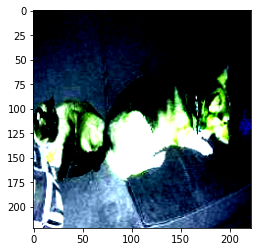

In [183]:
a = data[2].numpy()
a = np.moveaxis(a,0,-1)
plt.imshow(a)

In [172]:
from models.resnet import resnet18, resnet50
model = resnet18(pretrained=True, classes=args.n_classes, drop_perc=args.drop_perc)